In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import random

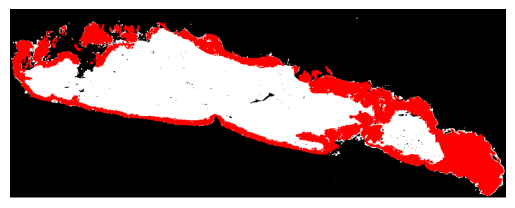

(374, 984, 3)


numpy.ndarray

In [2]:
def apply_mask():

    # Open the JPG and PNG images
    jpg_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/thumbnail.jpg' # path to the tissue slice
    png_mask_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/h1857578B  h&e_ROI_2-labels.png' # path to the epithelium slice
    
    jpg_image = Image.open(jpg_path).convert("RGB")
    png_mask = Image.open(png_mask_path).convert("RGBA")

    # Resize the mask to match the JPG dimensions if they differ
    if jpg_image.size != png_mask.size:
        png_mask = png_mask.resize(jpg_image.size, Image.LANCZOS)

    # Convert both images to numpy arrays
    jpg_array = np.array(jpg_image)
    mask_array = np.array(png_mask)

    # Create a mask for the PNG: True where the PNG is not white
    non_white_mask = ~np.all(mask_array[:, :, :3] > 200, axis=-1)  # Mask where PNG is not white

    # Create the final output image with a black background
    final_image_array = np.zeros_like(jpg_array)

    # Add white for stroma: Original white pixels in the JPG
    stroma_mask = np.all(jpg_array > 200, axis=-1)  # White pixels in JPG
    final_image_array[stroma_mask] = [0, 0, 0]  # Set stroma to white

    # Add red for mask: Areas in the PNG mask
    final_image_array[non_white_mask] = [254, 0, 0]  # Set mask areas to red
    mask = final_image_array
    # Set remaining original JPG pixels (not covered by PNG) to black
    non_masked_area = ~(stroma_mask | non_white_mask)  # Pixels not in stroma or mask
    final_image_array[non_masked_area] = [255, 255, 255]  # Set uncovered pixels to black

    # Convert back to PIL image
    final_image = Image.fromarray(final_image_array)

    return final_image, mask


   

image, mask = apply_mask()
filename = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/output.png' # where you want your output to go
image.save(filename)

# Display the final image
plt.imshow(image)
plt.axis("off")
plt.show()

mask[mask == 255] = 0 
# mask = Image.fromarray(mask)
# mask
print(mask.shape)
type(mask)

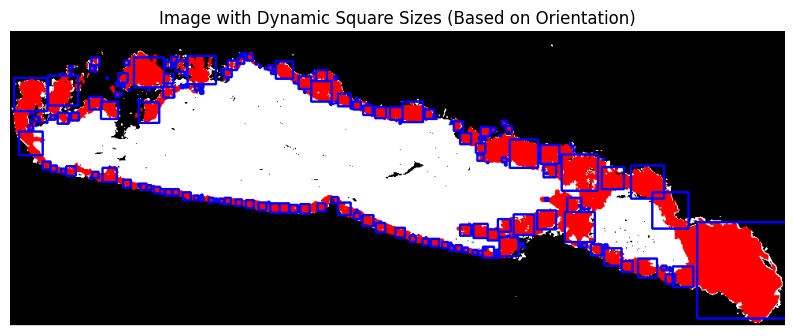

Rectangle 1 dimensions: Length = 14 pixels, Width = 14 pixels
Rectangle 2 dimensions: Length = 2 pixels, Width = 2 pixels
Rectangle 3 dimensions: Length = 12 pixels, Width = 12 pixels
Rectangle 4 dimensions: Length = 38 pixels, Width = 38 pixels
Rectangle 5 dimensions: Length = 2 pixels, Width = 2 pixels
Rectangle 6 dimensions: Length = 26 pixels, Width = 26 pixels
Rectangle 7 dimensions: Length = 6 pixels, Width = 6 pixels
Rectangle 8 dimensions: Length = 42 pixels, Width = 42 pixels
Rectangle 9 dimensions: Length = 24 pixels, Width = 24 pixels
Rectangle 10 dimensions: Length = 16 pixels, Width = 16 pixels
Rectangle 11 dimensions: Length = 2 pixels, Width = 2 pixels
Rectangle 12 dimensions: Length = 12 pixels, Width = 12 pixels
Rectangle 13 dimensions: Length = 46 pixels, Width = 46 pixels
Rectangle 14 dimensions: Length = 2 pixels, Width = 2 pixels
Rectangle 15 dimensions: Length = 38 pixels, Width = 38 pixels
Rectangle 16 dimensions: Length = 4 pixels, Width = 4 pixels
Rectangle 17 

In [54]:
# Load the image
image_path = '/Users/kotasuzuki/Desktop/STAT390_WI2025/Presentation 2/Thinkers/Kota Suzuki/images/output.png'
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Mask for black areas, white areas, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = mask

non_black_white_mask = np.any(non_black_white_mask>0, axis = 2).astype(int)

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = .7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Function to determine tissue orientation
def determine_orientation(mask):
    # Find non-zero epithelium pixels
    non_zero_coords = np.column_stack(np.where(mask > 0))
    
    if len(non_zero_coords) == 0:
        return None  # Return None if no tissue is present

    y_min, y_max = non_zero_coords[:, 0].min(), non_zero_coords[:, 0].max()
    x_min, x_max = non_zero_coords[:, 1].min(), non_zero_coords[:, 1].max()
    
    # Compare height and width of the bounding box
    height = y_max - y_min
    width = x_max - x_min
    return "vertical" if height > width else "horizontal"

# Updated function to calculate epithelium width
def calculate_epithelium_width(row_or_col, mask, orientation):
    if orientation == "horizontal":
        # Use vertical slice for horizontally oriented tissue
        slice_mask = mask[:, row_or_col] # looks at the column
    else:
        # Use horizontal slice for vertically oriented tissue
        slice_mask = mask[row_or_col, :]

    # Convert the mask slice to binary
    binary_slice = (slice_mask > 0).astype(int) # pixels along a column of the image where 1 represents epithelium

    # Anna new code
    # 1 means change from 0 to 1 and -1 means change from 1 to 0 in the binary slice
    diffs = np.diff(np.concatenate(([0],binary_slice,[0])))
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]
    widths = ends - starts
    middle_idx = np.floor((starts + ends)/2).astype(int)
    width_and_idx = np.column_stack((widths, middle_idx))
    return width_and_idx


# Function to calculate overlap
def calculate_overlap(new_coords, existing_coords):
    if len(new_coords) == 0:
        return 0 
    else:
        new_coords_set = set(new_coords)  # Convert to set of coordinates
        existing_coords_set = set(existing_coords)  # Convert to set of covered coordinates
        overlap = len(new_coords_set.intersection(existing_coords_set)) / len(new_coords_set)
        return overlap

# Initialize variables
covered_coordinates = set()
rectangles = []
attempts = 0

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < 1000:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random.seed(attempts)
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])

    ### KOTA NEW: Extract a local mask around the center point
    local_size = 400
    local_top, local_bottom = max(1, center_y - local_size // 2), min(non_black_white_mask.shape[0], center_y + local_size // 2)
    local_left, local_right = max(1, center_x - local_size // 2), min(non_black_white_mask.shape[1], center_x + local_size // 2)
    
    # Create a local mask based on this region
    local_mask = non_black_white_mask[local_top:local_bottom, local_left:local_right]
    
    # Determine local orientation dynamically
    tissue_orientation = determine_orientation(local_mask)
    if tissue_orientation is None: 
        continue 

    # Dynamically calculate the initial_size based on epithelium width
    if tissue_orientation == "horizontal":
        width_and_idx = calculate_epithelium_width(center_x, non_black_white_mask, tissue_orientation)
    elif tissue_orientation == "vertical":
        width_and_idx = calculate_epithelium_width(center_y, non_black_white_mask, tissue_orientation)
    
    # Anna new code
    new_square_coords_list = []

    for w, mid in width_and_idx:
        half_side = round((w * 1.1 )// 2)
        left = center_x - half_side
        top = mid - half_side
        right = center_x + half_side
        bottom = mid + half_side
        
        square_coords = np.array([(x, y) for x in range(left, right + 1) for y in range(top, bottom + 1)])

        square_coords_set = set(map(tuple, square_coords))

        # Check overlap with existing covered coordinates (starts as empty set)
        overlap = len(square_coords_set.intersection(covered_coordinates))/len(square_coords_set)

        # idk what this is for - anna
        vertical_preference = False
        
        if overlap <= 0.1: # if they aren't overlapping that much
            covered_coordinates.update(square_coords_set) # then now we have those coords covered
            rectangles.append((left, top, right, bottom)) # and that becomes a patch

            # Draw the rectangle
            color = (0, 255, 0) if vertical_preference else (255, 0, 0)
            cv2.rectangle(image, (left, top), (right, bottom), color, 2)

            # Remove these coordinates from the balanced points
            remove = np.isin(balanced_points, square_coords).all(axis = 1)
            balanced_points = np.array(balanced_points)
            balanced_points = balanced_points[~remove]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with Dynamic Square Sizes (Based on Orientation)")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

lengths = []

# Print dimensions of each final rectangle as Length x Width
for i, (left, top, right, bottom) in enumerate(rectangles, 1):
    length = bottom - top  # Height of the rectangle
    width = right - left   # Width of the rectangle
    lengths.append(length)
    
    print(f"Rectangle {i} dimensions: Length = {length} pixels, Width = {width} pixels")

import statistics as st
print(np.mean(lengths))
print(st.mode(lengths))


In [55]:
# Calculate the total mask area
total_mask_area = np.sum(non_black_white_mask > 0)

# Initialize variables to track patch areas and overlap
total_patch_area = 0            
patch_area_outside_mask = 0     
overlap_area = 0                

patch_masks = [] # stores binary masks for each patch so we can calculate overlaps later

# Loop through each patch defined by its bounding box
for (left, top, right, bottom) in rectangles:

    # Create a binary mask for the current patch
    patch_mask = np.zeros_like(non_black_white_mask, dtype=np.uint8)
    patch_mask[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)] = 1 # set the region corresponding to the current patch to 1 within image bounds

    # Calculate the area of the current patch
    patch_area = np.sum(patch_mask)
    total_patch_area += patch_area    

    # Calculate the area of the patch that falls outside the mask
    area_outside_mask = np.sum(patch_mask & (non_black_white_mask == 0))
    patch_area_outside_mask += area_outside_mask  

    # Calculate overlap with previously added patches
    for prev_patch in patch_masks:
        overlap_area += np.sum(patch_mask & prev_patch)

    # Add the current patch's binary mask to the list for future overlap calculations
    patch_masks.append(patch_mask)

# Percentage calculations
percent_mask_covered = (total_patch_area - patch_area_outside_mask) / total_mask_area * 100
percent_outside_mask = patch_area_outside_mask / total_patch_area * 100
percent_overlap = overlap_area / total_patch_area * 100

# Number of patches
num_patches = len(rectangles)

# Output results
print(f"% of Mask Area Covered: {percent_mask_covered:.2f}%")
print(f"% of Patch Area Outside Mask: {percent_outside_mask:.2f}%")
print(f"Number of Patches: {num_patches}")
print(f"% Patch Area Overlap: {percent_overlap:.2f}%")